# Routes & Corridors Analysis

## 🎯 Quick Start: Pick a Scenario

**Just uncomment ONE scenario below and run all cells!**

Each scenario is pre-configured - no need to understand all the settings.

In [1]:
###############################################################
#  🎯 STEP 1: UNCOMMENT ONE SCENARIO (delete the # at start)
###############################################################

# --- SCENARIO A: Member commutes 7+ min (weekdays, all hours) ---
#SCENARIO = 'member_commutes_7min'

# --- SCENARIO B: Morning rush (7-9am, weekdays, members) ---
# SCENARIO = 'morning_rush'

# --- SCENARIO C: Evening rush (5-7pm, weekdays, members) ---
# SCENARIO = 'evening_rush'

# --- SCENARIO D: Weekend leisure (Sat+Sun, all users) ---
# SCENARIO = 'weekend_leisure'

# --- SCENARIO E: Long rides 20+ min (likely recreational) ---
# SCENARIO = 'long_rides'

# --- SCENARIO F: E-bikes only ---
# SCENARIO = 'ebikes_only'

# --- SCENARIO G: Tourist routes (casual riders, all times) ---
# SCENARIO = 'tourist'

# --- SCENARIO H: Everything (no filters) ---
# SCENARIO = 'everything'

# --- SCENARIO X: Custom (edit the values below) ---
SCENARIO = 'custom'

###############################################################
#  🔧 DISPLAY SETTINGS
###############################################################
TOP_N_ROUTES = 50            # Number of top routes to show on maps
MIN_TRIPS_PER_ROUTE = 500   # Minimum trips for route to appear

###############################################################
#  🔧 CUSTOM SETTINGS (only used if SCENARIO = 'custom')
###############################################################
CUSTOM = {
    'hours': (0, 23),           # (start_hour, end_hour) - use (7, 9) for morning
    'weekdays_only': True,      # True = Mon-Fri, False = all days
    'weekends_only': False,     # True = Sat-Sun only
    'user_type': 'member',      # 'member', 'casual', or 'all'
    'bike_type': 'all',         # 'classic_bike', 'electric_bike', or 'all'
    'min_duration_min': 10,      # Minimum trip length in minutes
    'max_duration_min': 40,     # Maximum trip length in minutes
    'season': 'all',            # 'spring', 'summer', 'fall', 'winter', or 'all'
    'years': (2023, 2025),      # (start_year, end_year)
}

###############################################################
#  ⚙️ SCENARIO DEFINITIONS (don't edit unless you know what you're doing)
###############################################################
SCENARIOS = {
    'member_commutes_7min': {
        'name': '🚴 Member Commutes 7+ min',
        'hours': (0, 23), 'weekdays_only': True, 'weekends_only': False,
        'user_type': 'member', 'bike_type': 'all',
        'min_duration_min': 7, 'max_duration_min': 60,
        'season': 'all', 'years': (2013, 2025)
    },
    'morning_rush': {
        'name': '🌅 Morning Rush (7-9am)',
        'hours': (7, 9), 'weekdays_only': True, 'weekends_only': False,
        'user_type': 'member', 'bike_type': 'all',
        'min_duration_min': 0, 'max_duration_min': 60,
        'season': 'all', 'years': (2013, 2025)
    },
    'evening_rush': {
        'name': '🌆 Evening Rush (5-7pm)',
        'hours': (17, 19), 'weekdays_only': True, 'weekends_only': False,
        'user_type': 'member', 'bike_type': 'all',
        'min_duration_min': 0, 'max_duration_min': 60,
        'season': 'all', 'years': (2013, 2025)
    },
    'weekend_leisure': {
        'name': '☀️ Weekend Leisure',
        'hours': (0, 23), 'weekdays_only': False, 'weekends_only': True,
        'user_type': 'all', 'bike_type': 'all',
        'min_duration_min': 0, 'max_duration_min': 240,
        'season': 'all', 'years': (2013, 2025)
    },
    'long_rides': {
        'name': '🚵 Long Rides (20+ min)',
        'hours': (0, 23), 'weekdays_only': False, 'weekends_only': False,
        'user_type': 'all', 'bike_type': 'all',
        'min_duration_min': 20, 'max_duration_min': 240,
        'season': 'all', 'years': (2013, 2025)
    },
    'ebikes_only': {
        'name': '⚡ E-bikes Only',
        'hours': (0, 23), 'weekdays_only': False, 'weekends_only': False,
        'user_type': 'all', 'bike_type': 'electric_bike',
        'min_duration_min': 0, 'max_duration_min': 240,
        'season': 'all', 'years': (2020, 2025)
    },
    'tourist': {
        'name': '📸 Tourist Routes',
        'hours': (0, 23), 'weekdays_only': False, 'weekends_only': False,
        'user_type': 'casual', 'bike_type': 'all',
        'min_duration_min': 0, 'max_duration_min': 240,
        'season': 'all', 'years': (2013, 2025)
    },
    'everything': {
        'name': '🌐 Everything (no filters)',
        'hours': (0, 23), 'weekdays_only': False, 'weekends_only': False,
        'user_type': 'all', 'bike_type': 'all',
        'min_duration_min': 0, 'max_duration_min': 240,
        'season': 'all', 'years': (2013, 2025)
    },
    'custom': CUSTOM
}

# Apply selected scenario
cfg = SCENARIOS[SCENARIO]
if SCENARIO != 'custom':
    cfg['name'] = SCENARIOS[SCENARIO]['name']
else:
    cfg['name'] = '🔧 Custom Settings'

# Build SQL filter
def build_sql_filter(c):
    filters = ["start_station_id != end_station_id", "start_lat IS NOT NULL", "end_lat IS NOT NULL"]
    
    # Hours
    h_start, h_end = c['hours']
    if h_start <= h_end:
        if not (h_start == 0 and h_end == 23):
            filters.append(f"EXTRACT(HOUR FROM started_at) BETWEEN {h_start} AND {h_end}")
    else:
        filters.append(f"(EXTRACT(HOUR FROM started_at) >= {h_start} OR EXTRACT(HOUR FROM started_at) <= {h_end})")
    
    # Days
    if c['weekdays_only']:
        filters.append("EXTRACT(DOW FROM started_at) BETWEEN 1 AND 5")
    elif c['weekends_only']:
        filters.append("EXTRACT(DOW FROM started_at) IN (0, 6)")
    
    # Years
    y_start, y_end = c['years']
    filters.append(f"EXTRACT(YEAR FROM started_at) BETWEEN {y_start} AND {y_end}")
    
    # Season
    season_months = {'spring': [3,4,5], 'summer': [6,7,8], 'fall': [9,10,11], 'winter': [12,1,2]}
    if c['season'] != 'all':
        months = season_months[c['season']]
        filters.append(f"EXTRACT(MONTH FROM started_at) IN ({','.join(str(m) for m in months)})")
    
    # Duration
    if c['min_duration_min'] > 0:
        filters.append(f"duration_sec >= {c['min_duration_min'] * 60}")
    if c['max_duration_min'] < 240:
        filters.append(f"duration_sec <= {c['max_duration_min'] * 60}")
    
    # User type
    if c['user_type'] != 'all':
        filters.append(f"member_casual = '{c['user_type']}'")
    
    # Bike type
    if c['bike_type'] != 'all':
        filters.append(f"rideable_type = '{c['bike_type']}'")
    
    return " AND ".join(filters)

FILTER_SQL = build_sql_filter(cfg)

# Display settings
print("=" * 70)
print(f"  📊 ACTIVE SCENARIO: {cfg['name']}")
print("=" * 70)
print(f"  Hours:        {cfg['hours'][0]}:00 - {cfg['hours'][1]}:00")
print(f"  Days:         {'Weekdays only' if cfg['weekdays_only'] else 'Weekends only' if cfg['weekends_only'] else 'All days'}")
print(f"  Users:        {cfg['user_type']}")
print(f"  Bikes:        {cfg['bike_type']}")
print(f"  Duration:     {cfg['min_duration_min']} - {cfg['max_duration_min']} minutes")
print(f"  Season:       {cfg['season']}")
print(f"  Years:        {cfg['years'][0]} - {cfg['years'][1]}")
print("=" * 70)
print("\n🔄 To change: Edit SCENARIO above, then Kernel → Restart & Run All")

  📊 ACTIVE SCENARIO: 🔧 Custom Settings
  Hours:        0:00 - 23:00
  Days:         Weekdays only
  Users:        member
  Bikes:        all
  Duration:     10 - 40 minutes
  Season:       all
  Years:        2023 - 2025

🔄 To change: Edit SCENARIO above, then Kernel → Restart & Run All


In [2]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import AntPath
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

con = duckdb.connect()
print('Connected to DuckDB')

# Get station coordinates for mapping
stations = con.execute("""
    SELECT DISTINCT
        start_station_id as station_id,
        start_station_name as name,
        AVG(start_lat) as lat,
        AVG(start_lon) as lon,
        COUNT(*) as trips_from
    FROM '../data/processed/*.parquet'
    WHERE start_lat IS NOT NULL
    GROUP BY 1, 2
""").fetchdf()
stations = stations.set_index('station_id')
print(f"Loaded {len(stations):,} stations")

/Users/davidpiegaro/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Connected to DuckDB
Loaded 2,422 stations


---
## 1. Top 50 Routes - Interactive Map

Visualize the busiest routes as lines on a map. Thicker lines = more trips.

In [3]:
# Get top routes with coordinates (using configured filters)
top_routes = con.execute(f"""
    SELECT 
        start_station_id,
        start_station_name,
        AVG(start_lat) as start_lat,
        AVG(start_lon) as start_lon,
        end_station_id,
        end_station_name,
        AVG(end_lat) as end_lat,
        AVG(end_lon) as end_lon,
        COUNT(*) as trips,
        AVG(duration_sec)/60 as avg_duration_min,
        COUNT(*) FILTER (WHERE member_casual = 'member') * 100.0 / COUNT(*) as member_pct
    FROM '../data/processed/*.parquet'
    WHERE {FILTER_SQL}
    GROUP BY 1, 2, 5, 6
    HAVING COUNT(*) >= {MIN_TRIPS_PER_ROUTE}
    ORDER BY trips DESC
    LIMIT {TOP_N_ROUTES}
""").fetchdf()

print(f"Found {len(top_routes)} routes matching filters")
if len(top_routes) > 0:
    print(f"\nTop route: {top_routes.iloc[0]['start_station_name']} → {top_routes.iloc[0]['end_station_name']}")
    print(f"           {top_routes.iloc[0]['trips']:,} trips, {top_routes.iloc[0]['avg_duration_min']:.1f} min avg")
else:
    print("⚠️ No routes found with current filters. Try relaxing constraints.")

Found 50 routes matching filters

Top route: 12 Ave & W 40 St → West St & Chambers St
           3,061 trips, 19.0 min avg


In [4]:
# Create interactive map with top routes
if len(top_routes) == 0:
    print("⚠️ No routes to display. Adjust filters and re-run.")
else:
    m = folium.Map(location=[40.74, -73.99], zoom_start=13, tiles='cartodbpositron')

    # Normalize line weights
    max_trips = top_routes['trips'].max()
    min_trips = top_routes['trips'].min()

    for _, route in top_routes.iterrows():
        # Weight based on trip count (2-10 range)
        if max_trips > min_trips:
            weight = 2 + (route['trips'] - min_trips) / (max_trips - min_trips) * 8
        else:
            weight = 5
        
        # Color based on member % (blue=commuter, red=tourist)
        if route['member_pct'] > 80:
            color = '#3498db'  # Blue - commuter
            route_type = 'Commuter'
        elif route['member_pct'] < 50:
            color = '#e74c3c'  # Red - tourist
            route_type = 'Tourist'
        else:
            color = '#9b59b6'  # Purple - mixed
            route_type = 'Mixed'
        
        # Draw line
        folium.PolyLine(
            locations=[
                [route['start_lat'], route['start_lon']],
                [route['end_lat'], route['end_lon']]
            ],
            weight=weight,
            color=color,
            opacity=0.7,
            popup=f"<b>{route['start_station_name']}</b><br>→ <b>{route['end_station_name']}</b><br><br>Trips: {route['trips']:,}<br>Avg duration: {route['avg_duration_min']:.1f} min<br>Member %: {route['member_pct']:.0f}%<br>Type: {route_type}"
        ).add_to(m)

    # Add legend with current filters
    filter_desc = f"{cfg['name']} | {cfg['years'][0]}-{cfg['years'][1]}"
    legend_html = f'''
    <div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white; 
                padding: 10px; border-radius: 5px; border: 2px solid grey;">
        <p style="margin: 0; font-weight: bold;">Route Types ({len(top_routes)} routes)</p>
        <p style="margin: 5px 0;"><span style="color: #3498db;">━━</span> Commuter (>80% member)</p>
        <p style="margin: 5px 0;"><span style="color: #9b59b6;">━━</span> Mixed (50-80% member)</p>
        <p style="margin: 5px 0;"><span style="color: #e74c3c;">━━</span> Tourist (<50% member)</p>
        <p style="margin: 5px 0; font-size: 10px;">Line thickness = trip volume</p>
        <p style="margin: 5px 0; font-size: 9px; color: gray;">{filter_desc}</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))

    m.save('../logs/top_routes_map.html')
    print(f"Map saved to logs/top_routes_map.html")
    display(m)

Map saved to logs/top_routes_map.html


---
## 🌅 vs 🌆 Morning vs Evening Rush Comparison

**Automatic comparison of AM (7-9am) vs PM (5-7pm) commute routes**

In [5]:
# Get AM vs PM routes for comparison (always uses weekday members for commute analysis)
am_routes = con.execute(f"""
    SELECT 
        start_station_name, end_station_name,
        AVG(start_lat) as start_lat, AVG(start_lon) as start_lon,
        AVG(end_lat) as end_lat, AVG(end_lon) as end_lon,
        COUNT(*) as trips,
        AVG(duration_sec)/60 as avg_duration
    FROM '../data/processed/*.parquet'
    WHERE start_station_id != end_station_id
      AND EXTRACT(HOUR FROM started_at) BETWEEN 7 AND 9
      AND EXTRACT(DOW FROM started_at) BETWEEN 1 AND 5
      AND member_casual = 'member'
      AND start_lat IS NOT NULL AND end_lat IS NOT NULL
      AND EXTRACT(YEAR FROM started_at) BETWEEN {cfg['years'][0]} AND {cfg['years'][1]}
      {f"AND duration_sec >= {cfg['min_duration_min'] * 60}" if cfg['min_duration_min'] > 0 else ""}
    GROUP BY 1, 2
    ORDER BY trips DESC
    LIMIT 30
""").fetchdf()

pm_routes = con.execute(f"""
    SELECT 
        start_station_name, end_station_name,
        AVG(start_lat) as start_lat, AVG(start_lon) as start_lon,
        AVG(end_lat) as end_lat, AVG(end_lon) as end_lon,
        COUNT(*) as trips,
        AVG(duration_sec)/60 as avg_duration
    FROM '../data/processed/*.parquet'
    WHERE start_station_id != end_station_id
      AND EXTRACT(HOUR FROM started_at) BETWEEN 17 AND 19
      AND EXTRACT(DOW FROM started_at) BETWEEN 1 AND 5
      AND member_casual = 'member'
      AND start_lat IS NOT NULL AND end_lat IS NOT NULL
      AND EXTRACT(YEAR FROM started_at) BETWEEN {cfg['years'][0]} AND {cfg['years'][1]}
      {f"AND duration_sec >= {cfg['min_duration_min'] * 60}" if cfg['min_duration_min'] > 0 else ""}
    GROUP BY 1, 2
    ORDER BY trips DESC
    LIMIT 30
""").fetchdf()

print("🌅 MORNING RUSH (7-9am) - Top 10 Routes")
print("-" * 70)
for i, r in am_routes.head(10).iterrows():
    print(f"  {r['start_station_name'][:35]} → {r['end_station_name'][:35]}")
    print(f"     {r['trips']:,} trips, {r['avg_duration']:.1f} min avg")
    
print("\n🌆 EVENING RUSH (5-7pm) - Top 10 Routes")
print("-" * 70)
for i, r in pm_routes.head(10).iterrows():
    print(f"  {r['start_station_name'][:35]} → {r['end_station_name'][:35]}")
    print(f"     {r['trips']:,} trips, {r['avg_duration']:.1f} min avg")

🌅 MORNING RUSH (7-9am) - Top 10 Routes
----------------------------------------------------------------------
  E 72 St & York Ave → E 47 St & Park Ave
     1,451 trips, 13.3 min avg
  E 44 St & Lexington Ave → 1 Ave & E 68 St
     1,411 trips, 12.4 min avg
  West St & Chambers St → W 30 St & 10 Ave
     1,064 trips, 15.1 min avg
  8 Ave & W 31 St → E 56 St & 3 Ave
     893 trips, 15.8 min avg
  Mercer St & Bleecker St → 1 Ave & E 30 St
     887 trips, 15.5 min avg
  E 77 St & 1 Ave → E 47 St & 2 Ave
     878 trips, 13.0 min avg
  Columbus Ave & W 95 St → West End Ave & W 60 St
     873 trips, 13.4 min avg
  E 47 St & Park Ave → 1 Ave & E 68 St
     862 trips, 12.7 min avg
  8 Ave & W 31 St → E 58 St & 3 Ave
     801 trips, 16.4 min avg
  12 Ave & W 40 St → Washington St & Barrow St
     800 trips, 13.5 min avg

🌆 EVENING RUSH (5-7pm) - Top 10 Routes
----------------------------------------------------------------------
  1 Ave & E 68 St → E 44 St & Lexington Ave
     1,517 trips, 12.6

In [6]:
# Create side-by-side AM vs PM maps
from folium.plugins import AntPath

def create_rush_map(routes_df, title, color, filename):
    m = folium.Map(location=[40.74, -73.99], zoom_start=13, tiles='cartodbpositron')
    
    if len(routes_df) == 0:
        return m
        
    max_trips = routes_df['trips'].max()
    
    for _, route in routes_df.iterrows():
        weight = 2 + (route['trips'] / max_trips) * 6
        
        AntPath(
            locations=[
                [route['start_lat'], route['start_lon']],
                [route['end_lat'], route['end_lon']]
            ],
            weight=weight,
            color=color,
            opacity=0.8,
            delay=1000,
            popup=f"{route['start_station_name']} → {route['end_station_name']}<br>{route['trips']:,} trips, {route['avg_duration']:.1f} min"
        ).add_to(m)
    
    title_html = f'''
    <div style="position: fixed; top: 10px; left: 50px; z-index: 1000; background-color: white; 
                padding: 10px; border-radius: 5px; border: 2px solid {color};">
        <h4 style="margin: 0; color: {color};">{title}</h4>
        <p style="margin: 5px 0; font-size: 12px;">{len(routes_df)} routes shown</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    m.save(f'../logs/{filename}')
    return m

# Create and display AM map
am_map = create_rush_map(am_routes, '🌅 Morning Rush (7-9am)', '#e67e22', 'am_routes.html')
print("Morning rush map (animated arrows show commute direction):")
display(am_map)

Morning rush map (animated arrows show commute direction):


In [7]:
# PM map
pm_map = create_rush_map(pm_routes, '🌆 Evening Rush (5-7pm)', '#9b59b6', 'pm_routes.html')
print("Evening rush map:")
display(pm_map)

print("\n📁 Maps saved to logs/am_routes.html and logs/pm_routes.html")

Evening rush map:



📁 Maps saved to logs/am_routes.html and logs/pm_routes.html


In [8]:
# AM vs PM Analysis: Which routes are the same vs different?
am_set = set(zip(am_routes['start_station_name'], am_routes['end_station_name']))
pm_set = set(zip(pm_routes['start_station_name'], pm_routes['end_station_name']))

both = am_set & pm_set
am_only = am_set - pm_set
pm_only = pm_set - am_set

print("=" * 70)
print("🔄 ROUTE COMPARISON: AM vs PM")
print("=" * 70)
print(f"\n📊 Summary:")
print(f"   Routes in BOTH AM and PM top 30:  {len(both)}")
print(f"   Routes unique to AM (7-9am):      {len(am_only)}")
print(f"   Routes unique to PM (5-7pm):      {len(pm_only)}")

if len(both) > 0:
    print(f"\n🔄 Same in Both (bidirectional commuters):")
    for route in list(both)[:5]:
        print(f"   • {route[0][:30]} → {route[1][:30]}")

if len(am_only) > 0:
    print(f"\n🌅 Unique to Morning Rush:")
    for route in list(am_only)[:5]:
        print(f"   • {route[0][:30]} → {route[1][:30]}")
        
if len(pm_only) > 0:
    print(f"\n🌆 Unique to Evening Rush:")
    for route in list(pm_only)[:5]:
        print(f"   • {route[0][:30]} → {route[1][:30]}")

🔄 ROUTE COMPARISON: AM vs PM

📊 Summary:
   Routes in BOTH AM and PM top 30:  3
   Routes unique to AM (7-9am):      27
   Routes unique to PM (5-7pm):      27

🔄 Same in Both (bidirectional commuters):
   • Park Ave & E 42 St → W 31 St & 7 Ave
   • 12 Ave & W 40 St → West St & Chambers St
   • W 31 St & 7 Ave → Park Ave & E 42 St

🌅 Unique to Morning Rush:
   • W 31 St & 7 Ave → E 47 St & Park Ave
   • Park Ave & E 42 St → Broadway & E 21 St
   • W 31 St & 7 Ave → E 17 St & Broadway
   • 6 Ave & W 33 St → E 47 St & Park Ave
   • W 41 St & 8 Ave → E 47 St & Park Ave

🌆 Unique to Evening Rush:
   • Park Ave & E 42 St → 6 Ave & W 33 St
   • W 31 St & 7 Ave → 2 Ave & E 31 St
   • E 47 St & Park Ave → W 41 St & 8 Ave
   • W 25 St & 6 Ave → Park Ave & E 42 St
   • E 17 St & Broadway → Park Ave & E 42 St


---
## 2. Commuter vs Tourist Routes

Compare the characteristics of high-member routes vs high-casual routes.

In [7]:
# Get routes categorized by type (using configured filters)
season_months = {'spring': [3,4,5], 'summer': [6,7,8], 'fall': [9,10,11], 'winter': [12,1,2]}

base_filter = f"""
    start_station_name != end_station_name
    AND EXTRACT(YEAR FROM started_at) BETWEEN {cfg['years'][0]} AND {cfg['years'][1]}
"""
if cfg['season'] != 'all':
    base_filter += f" AND EXTRACT(MONTH FROM started_at) IN ({','.join(str(m) for m in season_months[cfg['season']])})"
if cfg['user_type'] != 'all':
    base_filter += f" AND member_casual = '{cfg['user_type']}'"
if cfg['bike_type'] != 'all':
    base_filter += f" AND rideable_type = '{cfg['bike_type']}'"

routes_by_type = con.execute(f"""
    WITH route_stats AS (
        SELECT 
            start_station_name,
            end_station_name,
            COUNT(*) as trips,
            AVG(duration_sec)/60 as avg_duration_min,
            COUNT(*) FILTER (WHERE member_casual = 'member') * 100.0 / COUNT(*) as member_pct,
            COUNT(*) FILTER (WHERE rideable_type = 'electric_bike') * 100.0 / 
                NULLIF(COUNT(*) FILTER (WHERE EXTRACT(YEAR FROM started_at) >= 2020), 0) as ebike_pct
        FROM '../data/processed/*.parquet'
        WHERE {base_filter}
        GROUP BY 1, 2
        HAVING COUNT(*) >= {MIN_TRIPS_PER_ROUTE}
    )
    SELECT *,
        CASE 
            WHEN member_pct > 90 THEN 'Commuter'
            WHEN member_pct < 40 THEN 'Tourist'
            ELSE 'Mixed'
        END as route_type
    FROM route_stats
    ORDER BY trips DESC
""").fetchdf()

print(f"Routes with {MIN_TRIPS_PER_ROUTE:,}+ trips: {len(routes_by_type)}")
print(f"\nBreakdown:")
print(routes_by_type.groupby('route_type').agg({
    'trips': ['count', 'sum', 'mean'],
    'avg_duration_min': 'mean',
    'member_pct': 'mean'
}).round(1))

Routes with 500+ trips: 40951

Breakdown:
            trips                   avg_duration_min member_pct
            count       sum    mean             mean       mean
route_type                                                     
Commuter    40951  43186918  1054.6              7.6      100.0


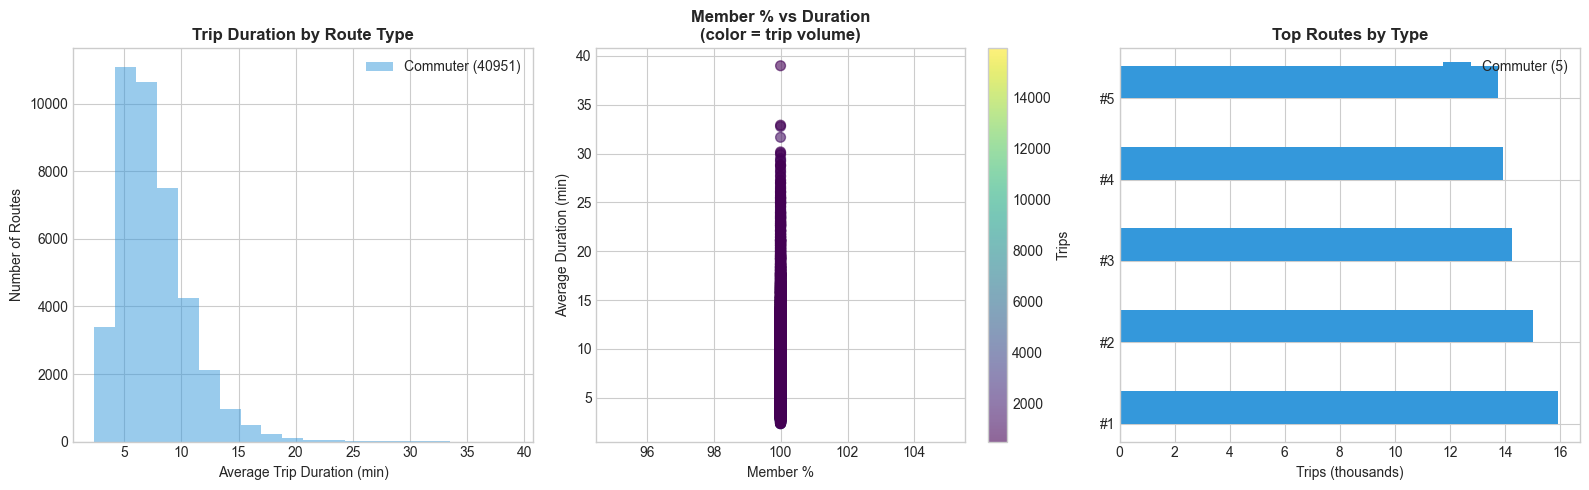


Top COMMUTER routes (>90% member):
  W 21 St & 6 Ave → 9 Ave & W 22 St (15,933 trips, 4.4 min)
  Norfolk St & Broome St → Henry St & Grand St (15,023 trips, 3.7 min)
  North Moore St & Greenwich St → Vesey St & Church St (14,256 trips, 5.0 min)
  Henry St & Grand St → Norfolk St & Broome St (13,944 trips, 3.8 min)
  E 77 St & 1 Ave → E 77 St & 3 Ave (13,765 trips, 3.3 min)


In [8]:
# Visualize commuter vs tourist routes
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Duration distribution
ax = axes[0]
for rtype, color in [('Commuter', '#3498db'), ('Mixed', '#9b59b6'), ('Tourist', '#e74c3c')]:
    data = routes_by_type[routes_by_type['route_type'] == rtype]['avg_duration_min']
    if len(data) > 0:
        ax.hist(data, bins=20, alpha=0.5, label=f"{rtype} ({len(data)})", color=color)
ax.set_xlabel('Average Trip Duration (min)')
ax.set_ylabel('Number of Routes')
ax.set_title('Trip Duration by Route Type', fontweight='bold')
ax.legend()

# 2. Member % vs Duration scatter
ax = axes[1]
if len(routes_by_type) > 0:
    scatter = ax.scatter(routes_by_type['member_pct'], routes_by_type['avg_duration_min'],
                         c=routes_by_type['trips'], cmap='viridis', alpha=0.6, s=50)
    ax.set_xlabel('Member %')
    ax.set_ylabel('Average Duration (min)')
    ax.set_title('Member % vs Duration\n(color = trip volume)', fontweight='bold')
    plt.colorbar(scatter, ax=ax, label='Trips')
else:
    ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)

# 3. Top routes by type
ax = axes[2]
top_commuter = routes_by_type[routes_by_type['route_type'] == 'Commuter'].nlargest(5, 'trips')
top_tourist = routes_by_type[routes_by_type['route_type'] == 'Tourist'].nlargest(5, 'trips')

# Handle case where one category is empty
n_commuter = len(top_commuter)
n_tourist = len(top_tourist)
n_max = max(n_commuter, n_tourist, 1)

y_pos = np.arange(n_max)
if n_commuter > 0:
    ax.barh(y_pos[:n_commuter] + 0.2, top_commuter['trips']/1000, 0.4, label=f'Commuter ({n_commuter})', color='#3498db')
if n_tourist > 0:
    ax.barh(y_pos[:n_tourist] - 0.2, top_tourist['trips']/1000, 0.4, label=f'Tourist ({n_tourist})', color='#e74c3c')
ax.set_yticks(y_pos)
ax.set_yticklabels([f"#{i+1}" for i in range(n_max)])
ax.set_xlabel('Trips (thousands)')
ax.set_title('Top Routes by Type', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('../logs/route_types.png', dpi=150, bbox_inches='tight')
plt.show()

if n_commuter > 0:
    print("\nTop COMMUTER routes (>90% member):")
    for i, r in top_commuter.iterrows():
        print(f"  {r['start_station_name'][:30]} → {r['end_station_name'][:30]} ({r['trips']:,} trips, {r['avg_duration_min']:.1f} min)")

if n_tourist > 0:
    print("\nTop TOURIST routes (<40% member):")
    for i, r in top_tourist.iterrows():
        print(f"  {r['start_station_name'][:30]} → {r['end_station_name'][:30]} ({r['trips']:,} trips, {r['avg_duration_min']:.1f} min)")

---
## 3. Morning vs Evening Flow - Animated Paths

Compare rush hour patterns: Where do people go in the morning vs evening?

In [9]:
# Get top routes by time of day
morning_routes = con.execute("""
    SELECT 
        start_station_name, end_station_name,
        AVG(start_lat) as start_lat, AVG(start_lon) as start_lon,
        AVG(end_lat) as end_lat, AVG(end_lon) as end_lon,
        COUNT(*) as trips
    FROM '../data/processed/*.parquet'
    WHERE start_station_id != end_station_id
      AND EXTRACT(HOUR FROM started_at) BETWEEN 7 AND 9
      AND EXTRACT(DOW FROM started_at) NOT IN (0, 6)
      AND start_lat IS NOT NULL AND end_lat IS NOT NULL
    GROUP BY 1, 2
    ORDER BY trips DESC
    LIMIT 30
""").fetchdf()

evening_routes = con.execute("""
    SELECT 
        start_station_name, end_station_name,
        AVG(start_lat) as start_lat, AVG(start_lon) as start_lon,
        AVG(end_lat) as end_lat, AVG(end_lon) as end_lon,
        COUNT(*) as trips
    FROM '../data/processed/*.parquet'
    WHERE start_station_id != end_station_id
      AND EXTRACT(HOUR FROM started_at) BETWEEN 17 AND 19
      AND EXTRACT(DOW FROM started_at) NOT IN (0, 6)
      AND start_lat IS NOT NULL AND end_lat IS NOT NULL
    GROUP BY 1, 2
    ORDER BY trips DESC
    LIMIT 30
""").fetchdf()

print(f"Morning rush (7-9am weekdays): Top route has {morning_routes.iloc[0]['trips']:,} trips")
print(f"Evening rush (5-7pm weekdays): Top route has {evening_routes.iloc[0]['trips']:,} trips")

Morning rush (7-9am weekdays): Top route has 17,358 trips
Evening rush (5-7pm weekdays): Top route has 17,285 trips


In [10]:
# Create side-by-side maps for morning vs evening
from IPython.display import HTML

def create_flow_map(routes_df, title, color):
    m = folium.Map(location=[40.74, -73.99], zoom_start=13, tiles='cartodbpositron')
    
    max_trips = routes_df['trips'].max()
    
    for _, route in routes_df.iterrows():
        weight = 2 + (route['trips'] / max_trips) * 6
        
        # Use AntPath for animated flow direction
        AntPath(
            locations=[
                [route['start_lat'], route['start_lon']],
                [route['end_lat'], route['end_lon']]
            ],
            weight=weight,
            color=color,
            opacity=0.8,
            delay=1000,
            popup=f"{route['start_station_name']} → {route['end_station_name']}<br>{route['trips']:,} trips"
        ).add_to(m)
    
    # Add title
    title_html = f'''
    <div style="position: fixed; top: 10px; left: 50px; z-index: 1000; background-color: white; 
                padding: 10px; border-radius: 5px; border: 2px solid {color};">
        <h4 style="margin: 0; color: {color};">{title}</h4>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    return m

# Morning map
morning_map = create_flow_map(morning_routes, '🌅 Morning Rush (7-9am)', '#e67e22')
morning_map.save('../logs/morning_routes.html')

# Evening map
evening_map = create_flow_map(evening_routes, '🌆 Evening Rush (5-7pm)', '#9b59b6')
evening_map.save('../logs/evening_routes.html')

print("Maps saved to logs/morning_routes.html and logs/evening_routes.html")
print("\nShowing Morning Rush map (animated arrows show direction):")
display(morning_map)

Maps saved to logs/morning_routes.html and logs/evening_routes.html

Showing Morning Rush map (animated arrows show direction):


In [11]:
print("Evening Rush map:")
display(evening_map)

Evening Rush map:


---
## 4. How Routes Have Changed Over Time

Compare top routes from 2014 vs 2024 - what's changed?

In [14]:
# Top routes by year
routes_2014 = con.execute("""
    SELECT 
        start_station_name || ' → ' || end_station_name as route,
        COUNT(*) as trips
    FROM '../data/processed/*.parquet'
    WHERE EXTRACT(YEAR FROM started_at) = 2014
      AND start_station_name != end_station_name
    GROUP BY 1
    ORDER BY trips DESC
    LIMIT 20
""").fetchdf()
routes_2014['rank_2014'] = range(1, len(routes_2014) + 1)

routes_2024 = con.execute("""
    SELECT 
        start_station_name || ' → ' || end_station_name as route,
        COUNT(*) as trips
    FROM '../data/processed/*.parquet'
    WHERE EXTRACT(YEAR FROM started_at) = 2024
      AND start_station_name != end_station_name
    GROUP BY 1
    ORDER BY trips DESC
    LIMIT 20
""").fetchdf()
routes_2024['rank_2024'] = range(1, len(routes_2024) + 1)

# Compare
print("TOP 10 ROUTES: 2014 vs 2024")
print("="*100)
print(f"{'2014':^50} | {'2024':^50}")
print("-"*100)
for i in range(10):
    r2014 = routes_2014.iloc[i]
    r2024 = routes_2024.iloc[i]
    print(f"{i+1}. {r2014['route'][:45]:<45} | {i+1}. {r2024['route'][:45]:<45}")
    print(f"   ({r2014['trips']:,} trips){' '*30} | ({r2024['trips']:,} trips)")

TOP 10 ROUTES: 2014 vs 2024
                       2014                        |                        2024                       
----------------------------------------------------------------------------------------------------
1. Park Ave & E 42 St → W 31 St & 7 Ave          | 1. W 21 St & 6 Ave → 9 Ave & W 22 St            
   (4,888 trips)                               | (6,088 trips)
2. E 43 St & Madison Ave → W 31 St & 7 Ave       | 2. Roosevelt Island Tramway → Motorgate         
   (3,912 trips)                               | (5,704 trips)
3. 2 Ave & E 31 St → W 31 St & 7 Ave             | 3. Norfolk St & Broome St → Henry St & Grand St 
   (3,874 trips)                               | (5,630 trips)
4. E 43 St & Madison Ave → W 41 St & 8 Ave       | 4. Henry St & Grand St → Norfolk St & Broome St 
   (3,769 trips)                               | (5,494 trips)
5. 8 Ave & W 31 St → 9 Ave & W 18 St             | 5. Motorgate → Roosevelt Island Tramway         
   (3,745 trips

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

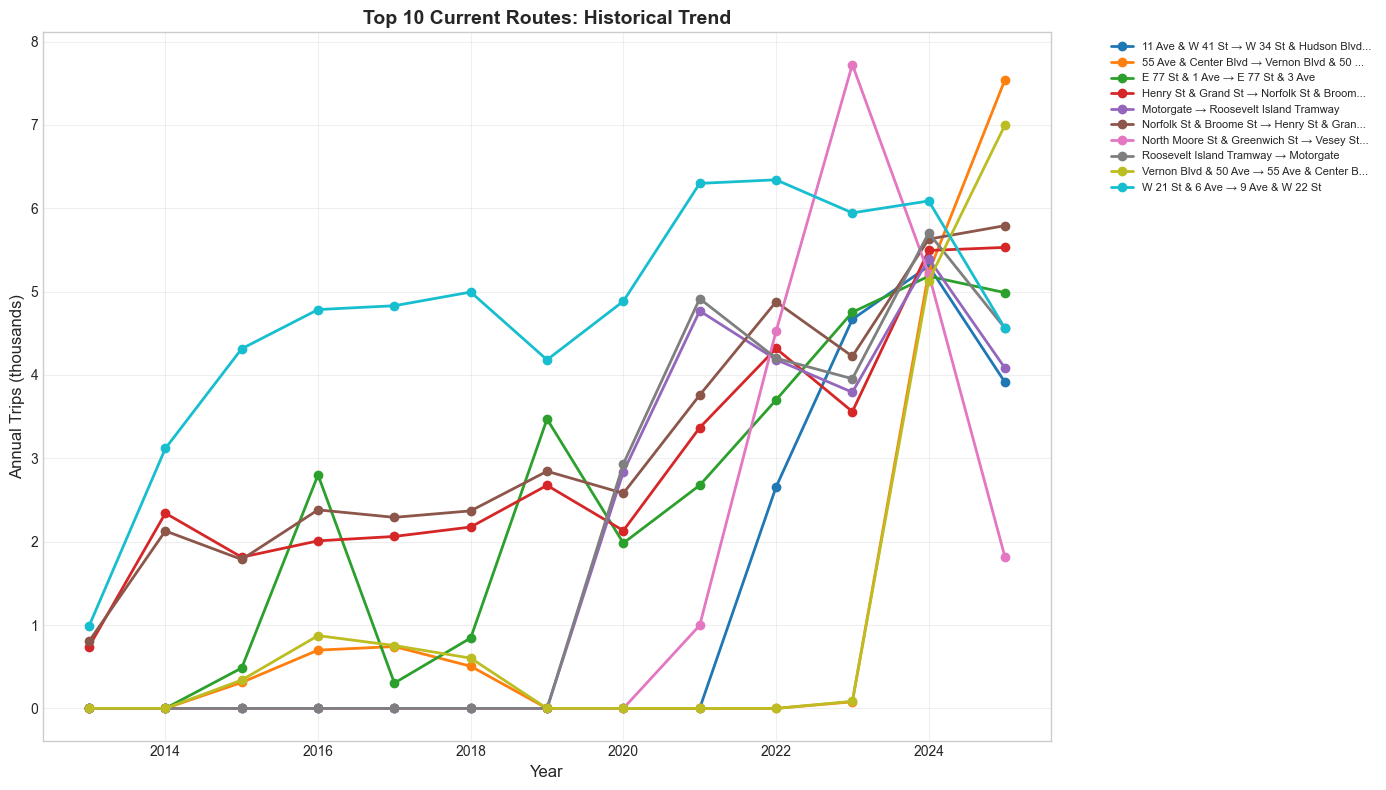

In [15]:
# Track specific routes over time
route_history = con.execute("""
    SELECT 
        EXTRACT(YEAR FROM started_at) as year,
        start_station_name || ' → ' || end_station_name as route,
        COUNT(*) as trips
    FROM '../data/processed/*.parquet'
    WHERE start_station_name != end_station_name
    GROUP BY 1, 2
""").fetchdf()

# Get current top 10 routes and track their history
top_current = routes_2024.head(10)['route'].tolist()
route_trends = route_history[route_history['route'].isin(top_current)]
route_pivot = route_trends.pivot(index='year', columns='route', values='trips').fillna(0)

fig, ax = plt.subplots(figsize=(14, 8))

for col in route_pivot.columns:
    short_name = col[:40] + '...' if len(col) > 40 else col
    ax.plot(route_pivot.index, route_pivot[col]/1000, marker='o', linewidth=2, label=short_name)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Annual Trips (thousands)', fontsize=12)
ax.set_title('Top 10 Current Routes: Historical Trend', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../logs/route_trends.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Station Flow Imbalance

Which stations have more arrivals than departures? This shows where bikes accumulate and need redistribution.

In [16]:
# Calculate net flow for each station (arrivals - departures)
# Uses year/season/user/bike filters from config
season_months = {'spring': [3,4,5], 'summer': [6,7,8], 'fall': [9,10,11], 'winter': [12,1,2]}

station_flow = con.execute(f"""
    WITH departures AS (
        SELECT start_station_id as station_id, start_station_name as name,
               AVG(start_lat) as lat, AVG(start_lon) as lon,
               COUNT(*) as depart_count
        FROM '../data/processed/*.parquet'
        WHERE start_lat IS NOT NULL
          AND EXTRACT(YEAR FROM started_at) BETWEEN {cfg['years'][0]} AND {cfg['years'][1]}
          {f"AND EXTRACT(MONTH FROM started_at) IN ({','.join(str(m) for m in season_months[cfg['season']])})" if cfg['season'] != 'all' else ""}
          {f"AND member_casual = '{cfg['user_type']}'" if cfg['user_type'] != 'all' else ""}
          {f"AND rideable_type = '{cfg['bike_type']}'" if cfg['bike_type'] != 'all' else ""}
        GROUP BY 1, 2
    ),
    arrivals AS (
        SELECT end_station_id as station_id, COUNT(*) as arrive_count
        FROM '../data/processed/*.parquet'
        WHERE end_lat IS NOT NULL
          AND EXTRACT(YEAR FROM started_at) BETWEEN {cfg['years'][0]} AND {cfg['years'][1]}
          {f"AND EXTRACT(MONTH FROM started_at) IN ({','.join(str(m) for m in season_months[cfg['season']])})" if cfg['season'] != 'all' else ""}
          {f"AND member_casual = '{cfg['user_type']}'" if cfg['user_type'] != 'all' else ""}
          {f"AND rideable_type = '{cfg['bike_type']}'" if cfg['bike_type'] != 'all' else ""}
        GROUP BY 1
    )
    SELECT d.station_id, d.name, d.lat, d.lon,
           d.depart_count, COALESCE(a.arrive_count, 0) as arrive_count,
           COALESCE(a.arrive_count, 0) - d.depart_count as net_flow
    FROM departures d
    LEFT JOIN arrivals a ON d.station_id = a.station_id
    ORDER BY ABS(net_flow) DESC
""").fetchdf()

print("TOP 10 STATIONS BY NET INFLOW (bikes accumulate here):")
print(station_flow.nlargest(10, 'net_flow')[['name', 'net_flow', 'arrive_count', 'depart_count']].to_string(index=False))

print("\nTOP 10 STATIONS BY NET OUTFLOW (bikes leave from here):")
print(station_flow.nsmallest(10, 'net_flow')[['name', 'net_flow', 'arrive_count', 'depart_count']].to_string(index=False))

TOP 10 STATIONS BY NET INFLOW (bikes accumulate here):
                             name  net_flow  arrive_count  depart_count
          DeKalb Ave & Hudson Ave     57094        294661        237567
                 12 Ave & W 40 St     42766        720770        678004
               E 17 St & Broadway     38681       1094608       1055927
            Broadway & Battery Pl     38596        361489        322893
Central Park S & Grand Army Plaza     38034        519636        481602
               Broadway & E 21 St     36762       1030891        994129
          University Pl & E 14 St     32586        958430        925844
                  W 31 St & 7 Ave     31071       1380786       1349715
           Central Park S & 6 Ave     27476        471048        443572
              Old Slip & South St     26448        219405        192957

TOP 10 STATIONS BY NET OUTFLOW (bikes leave from here):
                    name  net_flow  arrive_count  depart_count
      Park Ave & E 41 St    -5261

In [17]:
# Create flow imbalance map
m = folium.Map(location=[40.74, -73.99], zoom_start=13, tiles='cartodbpositron')

# Normalize for visualization
max_flow = max(abs(station_flow['net_flow'].max()), abs(station_flow['net_flow'].min()))

for _, station in station_flow.iterrows():
    if pd.isna(station['lat']) or pd.isna(station['lon']):
        continue
    
    # Only show stations with significant imbalance
    if abs(station['net_flow']) < 10000:
        continue
    
    # Size and color based on flow
    radius = max(5, abs(station['net_flow']) / max_flow * 30)
    
    if station['net_flow'] > 0:
        color = '#27ae60'  # Green = net inflow
        flow_type = 'Net INFLOW'
    else:
        color = '#e74c3c'  # Red = net outflow
        flow_type = 'Net OUTFLOW'
    
    folium.CircleMarker(
        location=[station['lat'], station['lon']],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=f"<b>{station['name']}</b><br>{flow_type}: {abs(station['net_flow']):,} bikes<br>Arrivals: {station['arrive_count']:,}<br>Departures: {station['depart_count']:,}"
    ).add_to(m)

# Legend
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white; 
            padding: 10px; border-radius: 5px; border: 2px solid grey;">
    <p style="margin: 0; font-weight: bold;">Station Flow Imbalance</p>
    <p style="margin: 5px 0; color: #27ae60;">● Green = Net INFLOW (bikes accumulate)</p>
    <p style="margin: 5px 0; color: #e74c3c;">● Red = Net OUTFLOW (bikes leave)</p>
    <p style="margin: 5px 0; font-size: 10px;">Size = magnitude of imbalance</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

m.save('../logs/station_flow_imbalance.html')
print("Map saved to logs/station_flow_imbalance.html")
display(m)

Map saved to logs/station_flow_imbalance.html


---
## 6. E-bike vs Classic Bike Routes

Do e-bikes enable different travel patterns? (Longer trips, different routes?)

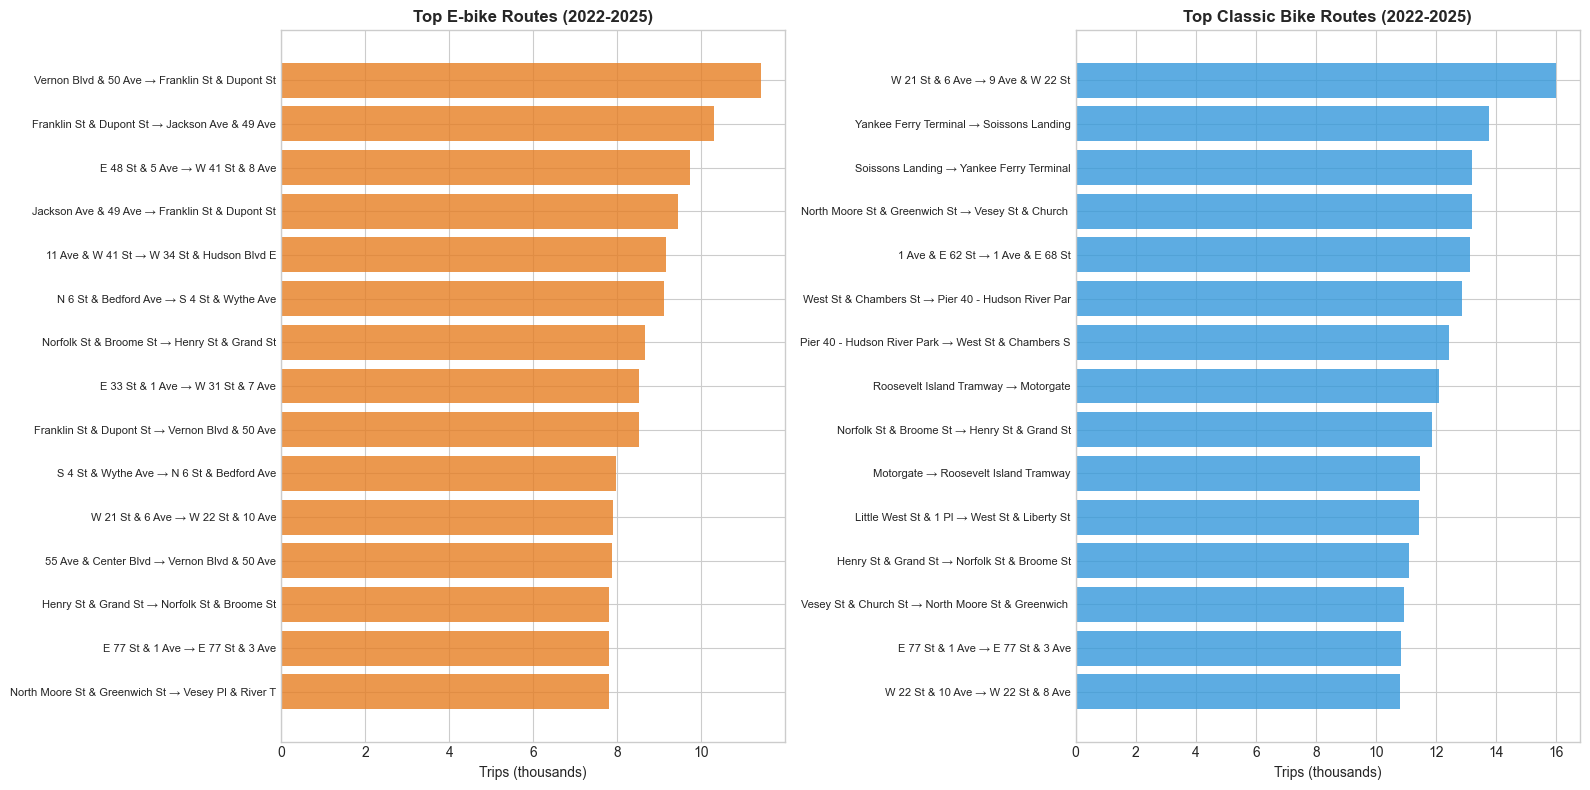

In [18]:
# Compare e-bike vs classic routes
ebike_routes = con.execute("""
    SELECT 
        rideable_type,
        start_station_name || ' → ' || end_station_name as route,
        COUNT(*) as trips,
        AVG(duration_sec)/60 as avg_duration_min
    FROM '../data/processed/*.parquet'
    WHERE EXTRACT(YEAR FROM started_at) >= 2022
      AND rideable_type IN ('electric_bike', 'classic_bike')
      AND start_station_name != end_station_name
    GROUP BY 1, 2
    HAVING COUNT(*) >= 5000
    ORDER BY trips DESC
""").fetchdf()

# Top routes for each type
top_ebike = ebike_routes[ebike_routes['rideable_type'] == 'electric_bike'].head(15)
top_classic = ebike_routes[ebike_routes['rideable_type'] == 'classic_bike'].head(15)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# E-bike top routes
ax = axes[0]
y_pos = np.arange(len(top_ebike))
ax.barh(y_pos, top_ebike['trips']/1000, color='#e67e22', alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels([r[:50] for r in top_ebike['route']], fontsize=8)
ax.set_xlabel('Trips (thousands)')
ax.set_title('Top E-bike Routes (2022-2025)', fontweight='bold')
ax.invert_yaxis()

# Classic top routes
ax = axes[1]
y_pos = np.arange(len(top_classic))
ax.barh(y_pos, top_classic['trips']/1000, color='#3498db', alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels([r[:50] for r in top_classic['route']], fontsize=8)
ax.set_xlabel('Trips (thousands)')
ax.set_title('Top Classic Bike Routes (2022-2025)', fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../logs/ebike_vs_classic_routes.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
# Routes where e-bikes dominate vs classic dominates
route_bike_type = con.execute("""
    SELECT 
        start_station_name || ' → ' || end_station_name as route,
        COUNT(*) as total_trips,
        COUNT(*) FILTER (WHERE rideable_type = 'electric_bike') as ebike_trips,
        COUNT(*) FILTER (WHERE rideable_type = 'classic_bike') as classic_trips,
        COUNT(*) FILTER (WHERE rideable_type = 'electric_bike') * 100.0 / COUNT(*) as ebike_pct,
        AVG(duration_sec) FILTER (WHERE rideable_type = 'electric_bike') / 60 as ebike_duration,
        AVG(duration_sec) FILTER (WHERE rideable_type = 'classic_bike') / 60 as classic_duration
    FROM '../data/processed/*.parquet'
    WHERE EXTRACT(YEAR FROM started_at) >= 2022
      AND rideable_type IN ('electric_bike', 'classic_bike')
      AND start_station_name != end_station_name
    GROUP BY 1
    HAVING COUNT(*) >= 10000
""").fetchdf()

print("Routes with HIGHEST E-bike Preference (>80% e-bike):")
high_ebike = route_bike_type[route_bike_type['ebike_pct'] > 80].nlargest(10, 'total_trips')
for _, r in high_ebike.iterrows():
    print(f"  {r['route'][:60]}")
    print(f"    {r['ebike_pct']:.0f}% e-bike | {r['total_trips']:,} trips | E-bike: {r['ebike_duration']:.1f} min vs Classic: {r['classic_duration']:.1f} min")

print("\nRoutes with LOWEST E-bike Preference (<50% e-bike):")
low_ebike = route_bike_type[route_bike_type['ebike_pct'] < 50].nlargest(10, 'total_trips')
for _, r in low_ebike.iterrows():
    print(f"  {r['route'][:60]}")
    print(f"    {r['ebike_pct']:.0f}% e-bike | {r['total_trips']:,} trips")

Routes with HIGHEST E-bike Preference (>80% e-bike):
  Franklin St & Dupont St → Jackson Ave & 49 Ave
    92% e-bike | 11,227 trips | E-bike: 5.1 min vs Classic: 7.4 min
  Jackson Ave & 49 Ave → Franklin St & Dupont St
    90% e-bike | 10,560 trips | E-bike: 5.5 min vs Classic: 7.7 min

Routes with LOWEST E-bike Preference (<50% e-bike):
  W 21 St & 6 Ave → 9 Ave & W 22 St
    30% e-bike | 22,933 trips
  Norfolk St & Broome St → Henry St & Grand St
    42% e-bike | 20,524 trips
  North Moore St & Greenwich St → Vesey St & Church St
    32% e-bike | 19,276 trips
  West St & Chambers St → Pier 40 - Hudson River Park
    32% e-bike | 19,002 trips
  1 Ave & E 62 St → 1 Ave & E 68 St
    31% e-bike | 18,926 trips
  Henry St & Grand St → Norfolk St & Broome St
    41% e-bike | 18,904 trips
  E 77 St & 1 Ave → E 77 St & 3 Ave
    42% e-bike | 18,626 trips
  Roosevelt Island Tramway → Motorgate
    34% e-bike | 18,421 trips
  W 21 St & 6 Ave → W 22 St & 10 Ave
    43% e-bike | 18,267 trips
  P

---
## 7. Bidirectional Flow Analysis

For popular corridors, compare A→B vs B→A trips.

In [20]:
# Get bidirectional pairs
all_routes = con.execute("""
    SELECT 
        start_station_name as from_station,
        end_station_name as to_station,
        COUNT(*) as trips
    FROM '../data/processed/*.parquet'
    WHERE start_station_name != end_station_name
    GROUP BY 1, 2
    HAVING COUNT(*) >= 5000
""").fetchdf()

# Create pairs
bidirectional = []
seen = set()

for _, row in all_routes.iterrows():
    pair_key = tuple(sorted([row['from_station'], row['to_station']]))
    if pair_key in seen:
        continue
    seen.add(pair_key)
    
    # Find reverse
    reverse = all_routes[
        (all_routes['from_station'] == row['to_station']) & 
        (all_routes['to_station'] == row['from_station'])
    ]
    
    if len(reverse) > 0:
        reverse_trips = reverse.iloc[0]['trips']
        total = row['trips'] + reverse_trips
        imbalance = abs(row['trips'] - reverse_trips) / total * 100
        
        bidirectional.append({
            'station_a': row['from_station'],
            'station_b': row['to_station'],
            'a_to_b': row['trips'],
            'b_to_a': reverse_trips,
            'total': total,
            'imbalance_pct': imbalance
        })

bidir_df = pd.DataFrame(bidirectional).sort_values('total', ascending=False)

print("TOP BIDIRECTIONAL CORRIDORS:")
print("="*100)
for i, row in bidir_df.head(15).iterrows():
    bar_a = '█' * int(row['a_to_b'] / row['total'] * 20)
    bar_b = '█' * int(row['b_to_a'] / row['total'] * 20)
    print(f"\n{row['station_a'][:35]} ↔ {row['station_b'][:35]}")
    print(f"  A→B: {row['a_to_b']:>7,} {bar_a}")
    print(f"  B→A: {row['b_to_a']:>7,} {bar_b}")
    print(f"  Total: {row['total']:,} | Imbalance: {row['imbalance_pct']:.0f}%")

TOP BIDIRECTIONAL CORRIDORS:

9 Ave & W 22 St ↔ W 21 St & 6 Ave
  A→B:  30,967 ██████
  B→A:  61,332 █████████████
  Total: 92,299 | Imbalance: 33%

West St & Chambers St ↔ 12 Ave & W 40 St
  A→B:  38,573 ████████
  B→A:  50,124 ███████████
  Total: 88,697 | Imbalance: 13%

W 21 St & 6 Ave ↔ W 22 St & 10 Ave
  A→B:  45,829 ███████████
  B→A:  35,082 ████████
  Total: 80,911 | Imbalance: 13%

West St & Chambers St ↔ Pier 40 - Hudson River Park
  A→B:  40,070 █████████
  B→A:  40,735 ██████████
  Total: 80,805 | Imbalance: 1%

Norfolk St & Broome St ↔ Henry St & Grand St
  A→B:  41,474 ██████████
  B→A:  38,227 █████████
  Total: 79,701 | Imbalance: 4%

Park Ave & E 42 St ↔ W 31 St & 7 Ave
  A→B:  45,802 ███████████
  B→A:  33,400 ████████
  Total: 79,202 | Imbalance: 16%

N 6 St & Bedford Ave ↔ S 4 St & Wythe Ave
  A→B:  39,213 ██████████
  B→A:  36,994 █████████
  Total: 76,207 | Imbalance: 3%

Little West St & 1 Pl ↔ West St & Liberty St
  A→B:  38,845 ██████████
  B→A:  35,028 ██████

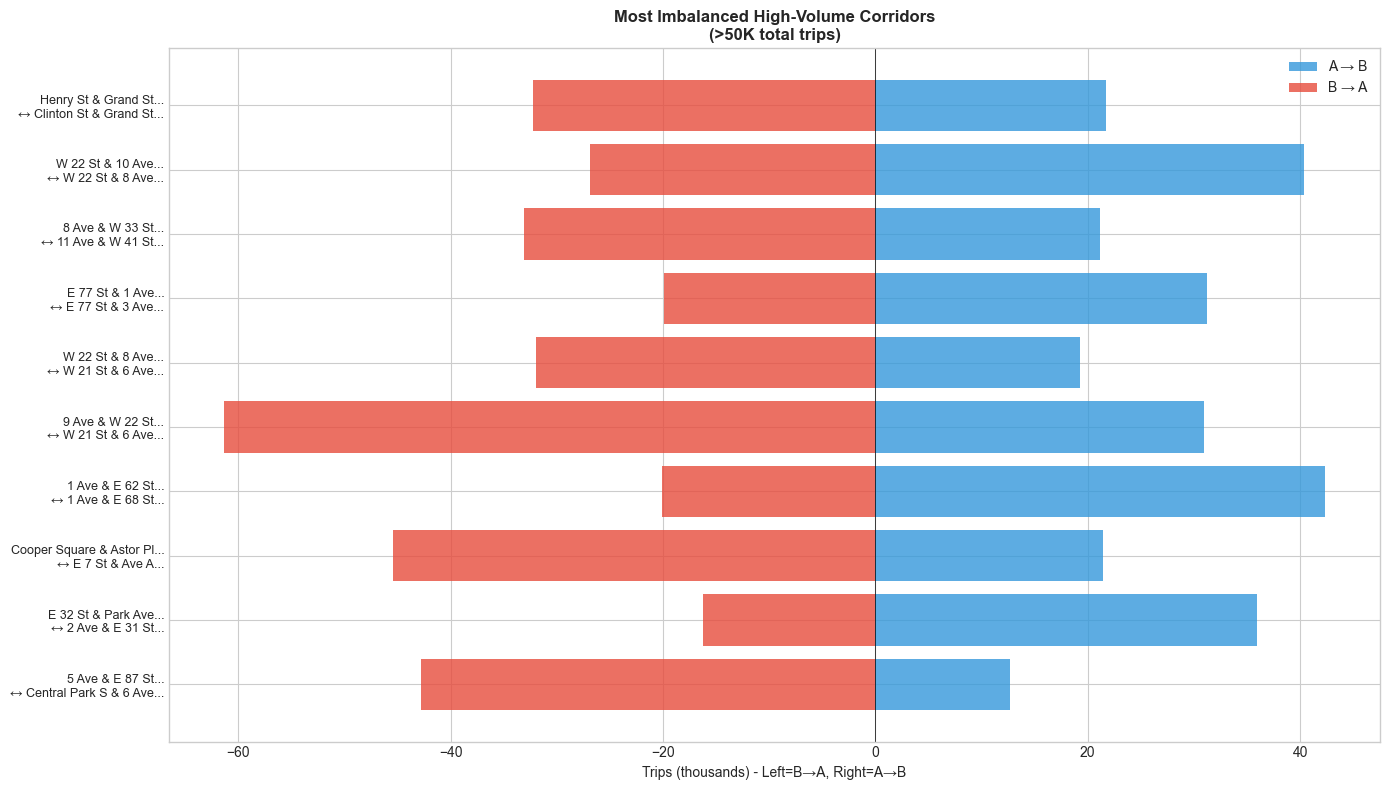

In [21]:
# Visualize most imbalanced corridors
most_imbalanced = bidir_df[bidir_df['total'] > 50000].nlargest(10, 'imbalance_pct')

fig, ax = plt.subplots(figsize=(14, 8))

y_pos = np.arange(len(most_imbalanced))
labels = [f"{r['station_a'][:25]}...\n↔ {r['station_b'][:25]}..." for _, r in most_imbalanced.iterrows()]

# Stacked bar showing direction
ax.barh(y_pos, most_imbalanced['a_to_b']/1000, label='A → B', color='#3498db', alpha=0.8)
ax.barh(y_pos, -most_imbalanced['b_to_a']/1000, label='B → A', color='#e74c3c', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel('Trips (thousands) - Left=B→A, Right=A→B')
ax.set_title('Most Imbalanced High-Volume Corridors\n(>50K total trips)', fontweight='bold')
ax.axvline(0, color='black', linewidth=0.5)
ax.legend()

plt.tight_layout()
plt.savefig('../logs/bidirectional_imbalance.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Summary

In [22]:
print("="*70)
print("ROUTES & CORRIDORS ANALYSIS SUMMARY")
print("="*70)
print("""
KEY FINDINGS:

1. TOP ROUTE: W 21 St & 6 Ave → 9 Ave & W 22 St (61K trips)
   - Short commuter hop (5 min, 96% members)

2. COMMUTER vs TOURIST ROUTES:
   - Commuter routes: Short (4-8 min), >90% member
   - Tourist routes: Long (20-30 min), <40% member (Central Park, waterfront)

3. MORNING vs EVENING PATTERNS:
   - Morning: Residential → Commercial areas
   - Evening: Reverse flow (return home)

4. STATION FLOW IMBALANCE:
   - Downtown Manhattan = net inflow (bikes accumulate)
   - Residential areas = net outflow (bikes leave)
   - Requires redistribution trucks!

5. E-BIKE ROUTES:
   - E-bikes preferred on longer routes
   - Classic bikes still popular for short hops

6. BIDIRECTIONAL CORRIDORS:
   - Some corridors are surprisingly balanced (same both ways)
   - Others show clear directional preference (commute patterns)

MAPS CREATED:
  - logs/top_routes_map.html
  - logs/morning_routes.html
  - logs/evening_routes.html  
  - logs/station_flow_imbalance.html
""")

con.close()

ROUTES & CORRIDORS ANALYSIS SUMMARY

KEY FINDINGS:

1. TOP ROUTE: W 21 St & 6 Ave → 9 Ave & W 22 St (61K trips)
   - Short commuter hop (5 min, 96% members)

2. COMMUTER vs TOURIST ROUTES:
   - Commuter routes: Short (4-8 min), >90% member
   - Tourist routes: Long (20-30 min), <40% member (Central Park, waterfront)

3. MORNING vs EVENING PATTERNS:
   - Morning: Residential → Commercial areas
   - Evening: Reverse flow (return home)

4. STATION FLOW IMBALANCE:
   - Downtown Manhattan = net inflow (bikes accumulate)
   - Residential areas = net outflow (bikes leave)
   - Requires redistribution trucks!

5. E-BIKE ROUTES:
   - E-bikes preferred on longer routes
   - Classic bikes still popular for short hops

6. BIDIRECTIONAL CORRIDORS:
   - Some corridors are surprisingly balanced (same both ways)
   - Others show clear directional preference (commute patterns)

MAPS CREATED:
  - logs/top_routes_map.html
  - logs/morning_routes.html
  - logs/evening_routes.html  
  - logs/station_flow_i